In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#!pip install wandb

In [1]:
import os
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import *
import seaborn as sns
sns.set()
#%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from scripts import utils
from scripts import metrics 
from scripts.dataset import SimpleSeqsDataset
from scripts.training import *

# from Bio import SeqIO
# from Bio.Seq import Seq
# from Bio.SeqRecord import SeqRecord
# from Bio.Alphabet import IUPAC
print(torch.__version__)
os.chdir('/content/drive/My Drive/DeepGQuad/Hybr/')

os.listdir()[:3]

1.4.0


['g_quadruplexes.png', '.DS_Store', 'Base.ipynb']

In [3]:
!wandb login 

In [2]:
df = pd.read_csv('./Data/G4_chip_all_coords.csv', sep='\t')
df.head()

,chr,true_start,true_end,start,end,seq,len
0,chr1,713977,714310,713894,714394,TTCAGCCGGCAACACACAGAACCTGGCGGGGAGGTCACTCTTACCA...,500
1,chr1,762850,762982,762666,763166,ACCGGACACAGACGCAGATCTGGCAGCTGAGCGACAGGCTTCGGAG...,500
2,chr1,840076,840205,839891,840391,ACGTGGCCTCCTCCGAACGCGGCCGCCTCCTCCTCCGAACGCGGCC...,500
3,chr1,894635,894796,894466,894966,GGTCACGCAGGAGTCACAGCTGCCCGCACGCCCAGCTCGCCCCAGC...,500
4,chr1,935414,935699,935307,935807,CTGCCATCGGCGAGGCGCTCGGTTTCCCCGGCGTGTCTGCGGCCAT...,500


In [3]:
# Generate labels
max_seq_len = 500
labels_col = []
for i, row in df.iterrows():
    labels = np.zeros(max_seq_len)
    labels[row.true_start-row.start:row.true_end - row.start] = 1
    labels_col.append(labels)
df['label'] = labels_col
df.head()

,chr,true_start,true_end,start,end,seq,len,label
0,chr1,713977,714310,713894,714394,TTCAGCCGGCAACACACAGAACCTGGCGGGGAGGTCACTCTTACCA...,500,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,chr1,762850,762982,762666,763166,ACCGGACACAGACGCAGATCTGGCAGCTGAGCGACAGGCTTCGGAG...,500,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,chr1,840076,840205,839891,840391,ACGTGGCCTCCTCCGAACGCGGCCGCCTCCTCCTCCGAACGCGGCC...,500,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,chr1,894635,894796,894466,894966,GGTCACGCAGGAGTCACAGCTGCCCGCACGCCCAGCTCGCCCCAGC...,500,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,chr1,935414,935699,935307,935807,CTGCCATCGGCGAGGCGCTCGGTTTCCCCGGCGTGTCTGCGGCCAT...,500,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [4]:
# Split to test & train
test_chromosomes_list = [3,6,9,12,15,18,21]
test_chromosomes = list(map(lambda n:'chr'+str(n),test_chromosomes_list))
specific_chromosomes = ['chrX','chrM','chrY']

test_data = df[df.chr.isin(test_chromosomes)].reset_index(drop=True)
train_data = df[~df.chr.isin(test_chromosomes + specific_chromosomes)].reset_index(drop=True)

In [5]:
# Get X & y
train_X = utils.encode_seq(train_data.seq)
testval_X = utils.encode_seq(test_data.seq)
train_y = train_data.label
testval_y = test_data.label


In [6]:
# Get validation set
val_part = int(0.7*test_data.shape[0])
print('Validation:', val_part)
val_X = testval_X[:val_part]
val_y = testval_y[:val_part]
print('Test:', test_data.shape[0]-val_part)
test_X = np.array(testval_X[val_part:])
test_y = np.array(testval_y[val_part:])

Validation: 1477
Test: 634


In [7]:
# Get train & val & test datasets
device = utils.get_device()  
BATCH_SIZE = 32
batch_num = len(train_X)//BATCH_SIZE
     
train_dataset = SimpleSeqsDataset(train_X, train_y)
validation_dataset = SimpleSeqsDataset(val_X, val_y)
test_dataset = SimpleSeqsDataset(test_X, test_y)

In [9]:
validation_dataset.__getitem__(0)[0]

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 1., 0.,  ..., 1., 0., 0.]])

In [16]:
!nvidia-smi

Fri May 29 15:41:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [8]:
max_seq_len = 500
class Net(nn.Module):
    def __init__(self, kernel_size=5, max_pool = 5):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4,out_channels=16, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(max_pool)
        self.input_size1 = 16*99
        self.fc1 = nn.Linear(self.input_size1, max_seq_len)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, self.input_size1)
        #x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc1(x))
        return torch.unsqueeze(x,1)
    
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4,out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool1d(5)
        self.conv2 = nn.Conv1d(in_channels=16,out_channels=32, kernel_size=5)
        self.fc1 = nn.Linear(32*19, max_seq_len)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32*19)
        #x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc1(x))
        return torch.unsqueeze(x,1)

class Net3(nn.Module):
    def __init__(self, kernel_size=5, max_pool = 5):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4,out_channels=16, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(max_pool)
        self.conv2 = nn.Conv1d(in_channels=16,out_channels=32, kernel_size=kernel_size)
        self.conv3 = nn.Conv1d(in_channels=2,out_channels=16, kernel_size=kernel_size)
        self.rnn = nn.GRU(32, 64, bidirectional = True)
        self.dropout = nn.Dropout(0.1)
        self.input_size1 = 16*12
        self.fc1 = nn.Linear(self.input_size1, max_seq_len)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.rnn(x.permute(2,0,1))
        x1, x2 = x
        x = torch.cat((x1[0:1,:,64:], x2[-1:,:,:64]),dim=0)
        x = x.permute(1,0,2)
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.contiguous().view(-1, self.input_size1)
        x = torch.sigmoid(self.fc1(x))
        return torch.unsqueeze(x,1)

class Net4(nn.Module):
    def __init__(self, kernel_size=5, max_pool = 5):
        super(Net4, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4,out_channels=16, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(max_pool)
        #self.conv2 = nn.Conv1d(in_channels=16,out_channels=32, kernel_size=kernel_size)
        self.conv3 = nn.Conv1d(in_channels=128,out_channels=16, kernel_size=kernel_size)
        self.rnn = nn.LSTM(16, 64, bidirectional = True)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(16*19, max_seq_len)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        #x = F.relu(self.conv2(x))
        #x = self.pool(x)
        x, (h, c) = self.rnn(x.permute(2,0,1))
        x = x.permute(1,2,0)
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.contiguous().view(-1, 16*19)
        #x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc1(x))
        return torch.unsqueeze(x,1)
    
net = Net4(5, 5)
print(net)

Net4(
  (conv1): Conv1d(4, 16, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 16, kernel_size=(5,), stride=(1,))
  (rnn): LSTM(16, 64, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=304, out_features=500, bias=True)
)


In [232]:
kernel_size = 7
max_pool = 5
net = Net3(kernel_size, max_pool)
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
#params = {'type':'cnn+bi-gru_a','layers':1, 'batch_size':32, 'dropout':0.4}
params = {'type':'cnn_s','layers':1, 'batch_size':32}
train(net, 30, params, eval_epochs = 2, new_run=True, save_model = True)

Epoch: 1, step:  100 | loss: 54.516 |  iou: 55.209
Epoch: 1, step:  200 | loss: 39.011 |  iou: 69.871
Epoch: 2, step:  100 | loss: 39.287 |  iou: 69.854
Epoch: 2, step:  200 | loss: 38.964 |  iou: 69.836
Validation:
Validation loss: 39.166 | Validation iou: 69.517
Best validation loss: 39.166
Saving model to ../logs/treasured-haze-147.pth.tar.
Epoch: 3, step:  100 | loss: 38.885 |  iou: 69.913
Epoch: 3, step:  200 | loss: 39.354 |  iou: 69.776
Epoch: 4, step:  100 | loss: 39.256 |  iou: 69.931
Epoch: 4, step:  200 | loss: 37.949 |  iou: 70.404
Validation:
Validation loss: 36.963 | Validation iou: 70.579
Best validation loss: 36.963
Saving model to ../logs/treasured-haze-147.pth.tar.
Epoch: 5, step:  100 | loss: 37.230 |  iou: 71.024
Epoch: 5, step:  200 | loss: 38.146 |  iou: 70.546
Epoch: 6, step:  100 | loss: 37.958 |  iou: 70.741
Epoch: 6, step:  200 | loss: 37.079 |  iou: 71.019
Validation:
Validation loss: 36.641 | Validation iou: 70.720
Best validation loss: 36.641
Saving model t

In [9]:
net = Net4()
net = load_model(net, './results/Hybrid models/light-dawn-42.pth.tar')

Model's state_dict:
conv1.weight 	 torch.Size([16, 4, 5])
conv1.bias 	 torch.Size([16])
conv3.weight 	 torch.Size([16, 128, 5])
conv3.bias 	 torch.Size([16])
rnn.weight_ih_l0 	 torch.Size([256, 16])
rnn.weight_hh_l0 	 torch.Size([256, 64])
rnn.bias_ih_l0 	 torch.Size([256])
rnn.bias_hh_l0 	 torch.Size([256])
rnn.weight_ih_l0_reverse 	 torch.Size([256, 16])
rnn.weight_hh_l0_reverse 	 torch.Size([256, 64])
rnn.bias_ih_l0_reverse 	 torch.Size([256])
rnn.bias_hh_l0_reverse 	 torch.Size([256])
fc1.weight 	 torch.Size([500, 304])
fc1.bias 	 torch.Size([500])
Net4(
  (conv1): Conv1d(4, 16, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 16, kernel_size=(5,), stride=(1,))
  (rnn): LSTM(16, 64, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=304, out_features=500, bias=True)
)


In [10]:
y_labels_list, y_pred_list = evaluation(net, test_dataset, batch_size = BATCH_SIZE)

IoU: 72.318, acc 84.300


In [0]:
#best
#cnn+bi-gru+dropout 0.2 + cnn IoU: 72.102 | Acc: 84.197
#cnn+bi-lstm+dropout 0.4 + cnn  IoU: 72.334 | Acc: 84.300
#random IoU: 33.327 | Acc: 50.250

In [293]:
pred = [0.0804, 0.0576, 0.0644, 0.0485, 0.0339, 0.0412, 0.0740, 0.1110, 0.0556,
         0.0465, 0.0747, 0.1113, 0.0698, 0.0763, 0.0404, 0.0657, 0.0395, 0.0268,
         0.0802, 0.0706, 0.0352, 0.0721, 0.0370, 0.0723, 0.0657, 0.0346, 0.0334,
         0.0559, 0.0461, 0.1589, 0.0474, 0.0602, 0.0791, 0.0625, 0.0634, 0.0576,
         0.0814, 0.0956, 0.0900, 0.1572, 0.0344, 0.1246, 0.1055, 0.0865, 0.0493,
         0.0853, 0.0879, 0.1583, 0.0854, 0.1028, 0.0604, 0.1159, 0.1447, 0.1390,
         0.1375, 0.1258, 0.1318, 0.0490, 0.1477, 0.1052, 0.1589, 0.0968, 0.2023,
         0.1024, 0.1601, 0.1016, 0.1124, 0.0704, 0.1269, 0.2120, 0.0798, 0.2363,
         0.1354, 0.2176, 0.1737, 0.1953, 0.2348, 0.3142, 0.2097, 0.1134, 0.1326,
         0.1770, 0.1148, 0.1948, 0.2271, 0.1576, 0.1332, 0.2178, 0.1956, 0.1037,
         0.1639, 0.1217, 0.1894, 0.2002, 0.1479, 0.2117, 0.2338, 0.2594, 0.1704,
         0.2571, 0.1602, 0.3299, 0.2354, 0.3720, 0.3153, 0.2207, 0.4067, 0.3175,
         0.2174, 0.3315, 0.4308, 0.2461, 0.3928, 0.3305, 0.3008, 0.3089, 0.3677,
         0.4254, 0.4216, 0.2612, 0.3212, 0.3726, 0.4290, 0.2727, 0.3651, 0.6628,
         0.3097, 0.4649, 0.4732, 0.4547, 0.4158, 0.3736, 0.4069, 0.3439, 0.4584,
         0.3838, 0.5989, 0.3839, 0.5490, 0.6094, 0.3547, 0.5219, 0.5715, 0.5064,
         0.6440, 0.5273, 0.7052, 0.7741, 0.7287, 0.7254, 0.5112, 0.7478, 0.5245,
         0.6693, 0.7820, 0.7741, 0.7189, 0.6595, 0.6930, 0.8028, 0.6569, 0.6115,
         0.7800, 0.8019, 0.5566, 0.7682, 0.7479, 0.7257, 0.7448, 0.9032, 0.7833,
         0.8517, 0.7788, 0.7354, 0.7768, 0.6307, 0.7933, 0.8351, 0.8369, 0.7655,
         0.8600, 0.8810, 0.8431, 0.8778, 0.8362, 0.9124, 0.9000, 0.8405, 0.8940,
         0.8373, 0.8653, 0.9217, 0.8596, 0.9235, 0.9156, 0.9504, 0.9170, 0.9431,
         0.9201, 0.9475, 0.9584, 0.9005, 0.9412, 0.9143, 0.9427, 0.9247, 0.9142,
         0.9489, 0.9505, 0.9712, 0.9660, 0.9381, 0.9727, 0.9215, 0.9544, 0.9522,
         0.9655, 0.9499, 0.9564, 0.9687, 0.9764, 0.9490, 0.9459, 0.9399, 0.9696,
         0.9436, 0.9664, 0.9424, 0.9573, 0.9586, 0.9707, 0.9542, 0.9525, 0.9771,
         0.9637, 0.9840, 0.9651, 0.9645, 0.9413, 0.9650, 0.9798, 0.9802, 0.9648,
         0.9695, 0.9679, 0.9535, 0.9690, 0.9427, 0.9572, 0.9857, 0.9494, 0.9659,
         0.9640, 0.9636, 0.9814, 0.9631, 0.9783, 0.9626, 0.9754, 0.9697, 0.9728,
         0.9516, 0.9464, 0.9655, 0.9576, 0.9463, 0.9712, 0.9802, 0.9679, 0.9548,
         0.9685, 0.9677, 0.9701, 0.9671, 0.9606, 0.9681, 0.9670, 0.9582, 0.9591,
         0.9655, 0.9686, 0.9417, 0.9740, 0.9605, 0.9424, 0.9260, 0.9362, 0.9003,
         0.9675, 0.9361, 0.9206, 0.9408, 0.9637, 0.9510, 0.9306, 0.9506, 0.9122,
         0.9288, 0.9277, 0.9015, 0.9425, 0.9024, 0.8476, 0.9286, 0.8453, 0.9353,
         0.9199, 0.8029, 0.9152, 0.8409, 0.8854, 0.8283, 0.9020, 0.9153, 0.8899,
         0.9092, 0.8585, 0.7458, 0.8878, 0.8546, 0.8633, 0.7755, 0.8392, 0.8604,
         0.8278, 0.8074, 0.7885, 0.5991, 0.8216, 0.7308, 0.7209, 0.7402, 0.6556,
         0.6446, 0.8703, 0.5908, 0.7237, 0.6754, 0.7197, 0.4731, 0.6687, 0.6671,
         0.5991, 0.6891, 0.4235, 0.8247, 0.6832, 0.6669, 0.6729, 0.6810, 0.8131,
         0.4732, 0.6002, 0.5643, 0.5667, 0.6744, 0.4945, 0.6050, 0.6838, 0.5435,
         0.4156, 0.5826, 0.5397, 0.4812, 0.5846, 0.5953, 0.5846, 0.5281, 0.3686,
         0.2207, 0.4646, 0.4896, 0.3830, 0.4107, 0.2595, 0.4415, 0.5145, 0.5106,
         0.4246, 0.4638, 0.3339, 0.3830, 0.2219, 0.2204, 0.2617, 0.3042, 0.3263,
         0.2898, 0.4590, 0.4624, 0.1730, 0.1982, 0.2709, 0.2863, 0.2225, 0.1473,
         0.2040, 0.2217, 0.2280, 0.2026, 0.2523, 0.2970, 0.1786, 0.1486, 0.1457,
         0.2284, 0.2127, 0.1523, 0.1036, 0.1186, 0.1941, 0.2299, 0.1351, 0.1802,
         0.0871, 0.1898, 0.0861, 0.1706, 0.1605, 0.1746, 0.1123, 0.1511, 0.1231,
         0.1133, 0.1083, 0.1612, 0.1364, 0.1170, 0.2439, 0.1996, 0.1810, 0.0714,
         0.1173, 0.1485, 0.1334, 0.2335, 0.0901, 0.0790, 0.1453, 0.0956, 0.2016,
         0.0726, 0.1250, 0.0498, 0.0679, 0.1052, 0.0490, 0.1305, 0.1186, 0.1986,
         0.0538, 0.0656, 0.0474, 0.0558, 0.1039, 0.1285, 0.0744, 0.1166, 0.0385,
         0.0769, 0.1774, 0.0809, 0.0767, 0.1120, 0.0528, 0.1418, 0.0553, 0.0757,
         0.0720, 0.0457, 0.0478, 0.0467, 0.0660, 0.0910, 0.1168, 0.0517, 0.1017,
         0.1011, 0.1143, 0.0556, 0.0571, 0.0814, 0.0997, 0.0330, 0.1041, 0.1167,
         0.0243, 0.0552, 0.0510, 0.0539, 0.0935, 0.0796, 0.0448, 0.0481, 0.0724,
         0.0490, 0.0439, 0.0383, 0.0668, 0.0630]
a

[0.0804,
 0.0576,
 0.0644,
 0.0485,
 0.0339,
 0.0412,
 0.074,
 0.111,
 0.0556,
 0.0465,
 0.0747,
 0.1113,
 0.0698,
 0.0763,
 0.0404,
 0.0657,
 0.0395,
 0.0268,
 0.0802,
 0.0706,
 0.0352,
 0.0721,
 0.037,
 0.0723,
 0.0657,
 0.0346,
 0.0334,
 0.0559,
 0.0461,
 0.1589,
 0.0474,
 0.0602,
 0.0791,
 0.0625,
 0.0634,
 0.0576,
 0.0814,
 0.0956,
 0.09,
 0.1572,
 0.0344,
 0.1246,
 0.1055,
 0.0865,
 0.0493,
 0.0853,
 0.0879,
 0.1583,
 0.0854,
 0.1028,
 0.0604,
 0.1159,
 0.1447,
 0.139,
 0.1375,
 0.1258,
 0.1318,
 0.049,
 0.1477,
 0.1052,
 0.1589,
 0.0968,
 0.2023,
 0.1024,
 0.1601,
 0.1016,
 0.1124,
 0.0704,
 0.1269,
 0.212,
 0.0798,
 0.2363,
 0.1354,
 0.2176,
 0.1737,
 0.1953,
 0.2348,
 0.3142,
 0.2097,
 0.1134,
 0.1326,
 0.177,
 0.1148,
 0.1948,
 0.2271,
 0.1576,
 0.1332,
 0.2178,
 0.1956,
 0.1037,
 0.1639,
 0.1217,
 0.1894,
 0.2002,
 0.1479,
 0.2117,
 0.2338,
 0.2594,
 0.1704,
 0.2571,
 0.1602,
 0.3299,
 0.2354,
 0.372,
 0.3153,
 0.2207,
 0.4067,
 0.3175,
 0.2174,
 0.3315,
 0.4308,
 0.2461,
 0

In [0]:
true =[ 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

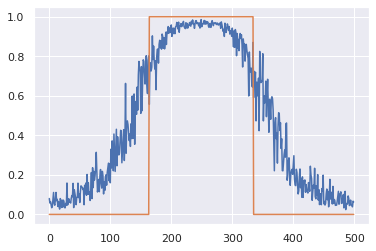

In [295]:
plt.plot(np.arange(0,len(pred)),pred)
plt.plot(np.arange(0,len(true)),true)